<a href="https://colab.research.google.com/github/nightcrawler321/202106_rs_assignment/blob/master/cear_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Connect Git directory with google colab folder

In [ ]:
!git clone https://github.com/energyandcleanair/202106_rs_assignment.git

fatal: destination path '202106_rs_assignment' already exists and is not an empty directory.


### Installation of required labraries

In [ ]:
!pip install rasterio
!pip install geopandas
!pip install pycrs
!pip install rioxarray
!pip install earthpy
!pip install pycrs

## Wind speed and direction 

In [ ]:
WS=[]
WD=[]
day_list=['0526','0527','0528','0529','0530','0531','0601','0602']
for i in  day_list:
  import rasterio
  import numpy as np
  dataset = rasterio.open('/content/202106_rs_assignment/data/era5_paris_2020'+i+'.tif')
  bandu=dataset.read(1)
  bandv=dataset.read(2)
  
  #magnitude of equivalent wind speed
  u2=bandu*bandu
  v2=bandv*bandv
  bandws=np.sqrt(u2+v2)#magnitude of equivalent wind in m/s
  wind_speed=(3.6*bandws)
  #wind direction
  wind_dir=np.arctan2(bandu,bandv) # wind direction is in radian
  wind_dir=wind_dir*57.2958 #wind direction in degree (1 rad=57.2958 degree)

  x, y = (2.3522,48.8566)
  row, col = dataset.index(x, y)
  
  #wind direction and wind angle at given location i.e paris(2.3522° N,48.8566° E)
  #band1 = datasetno.read(1)
  WS.append(wind_speed[row,col])
  WD.append(wind_dir[row,col])
  print('wind speed on Paris Center on 2020'+i,'=', wind_speed[row, col])
  
  print('wind direction on Paris Center on 2020'+i,'=', wind_dir[row, col])
  






wind speed on Paris Center on 20200526 = 10.875385
wind direction on Paris Center on 20200526 = -143.12173
wind speed on Paris Center on 20200527 = 12.977073
wind direction on Paris Center on 20200527 = -152.00859
wind speed on Paris Center on 20200528 = 15.360531
wind direction on Paris Center on 20200528 = -142.23305
wind speed on Paris Center on 20200529 = 13.296298
wind direction on Paris Center on 20200529 = -119.59887
wind speed on Paris Center on 20200530 = 11.215533
wind direction on Paris Center on 20200530 = -105.22217
wind speed on Paris Center on 20200531 = 13.303039
wind direction on Paris Center on 20200531 = -116.26538
wind speed on Paris Center on 20200601 = 11.184656
wind direction on Paris Center on 20200601 = -123.299324
wind speed on Paris Center on 20200602 = 6.5969396
wind direction on Paris Center on 20200602 = -145.66624


##Clipping raster field around Paris Center in radius of 60 km

In [ ]:
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
import os
%matplotlib inline

In [ ]:
# Filepaths
for i in  day_list:
  import warnings
  warnings.simplefilter(action='ignore', category=FutureWarning)

  fp = r'/content/202106_rs_assignment/data/no2_paris_2020'+i+'.tif'

  out_tif = r'cliped_no2_paris_2020'+i+'.tif'

  #Show your original data
  #data = rasterio.open(fp)
  #show((data, 1))

  #get co-ordinate values
  #coords = getFeatures(geo)
  #print(coords)
# define your WGS84 coordinates
  minx, miny = 2.0819, 48.5863

  maxx, maxy = 2.6225, 49.1269

  bbox = box(minx, miny, maxx, maxy)

  geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
  geo = geo.to_crs(crs=data.crs.data)
  
  def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]
  coords = getFeatures(geo)
  # Clip the raster with Polygon
  out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)
  # Copy the metadata
  out_meta = data.meta.copy()
  #print(out_meta)

  # Parse EPSG code
  epsg_code = int(data.crs.data['init'][5:])
  #print(epsg_code)

  out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()}
                         )
  #with rasterio.open(out_tif, "w", **out_meta) as dest:
        #dest.write(out_img)
  # Open the clipped raster file
  #clipped = rasterio.open(out_tif)

  # Visualize
  #show((clipped, 1))

  # Parse EPSG code
  epsg_code = int(data.crs.data['init'][5:])
  #print(epsg_code)

  out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()}
                         )
  with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(out_img)
  # Open the clipped raster file
  #clipped = rasterio.open(out_tif)

  # Visualize
  #show((clipped, 1))




## Reprojection and Resampling (coarse resolution) and density line

In [ ]:

for i in  day_list:
  import numpy as np
  import rasterio
  from rasterio.warp import calculate_default_transform, reproject, Resampling
  
#list of destination crs for each day based on wind direction

  dst_crs_0526 = '<99999> +proj=tmerc +ellps=WGS84 +datum=WGS84 +units=m +no_defs +lon_0=-37 +x_0=500000 +y_0=0 +k_0=0.9996'
  dst_crs_0527 = '<99999> +proj=tmerc +ellps=WGS84 +datum=WGS84 +units=m +no_defs +lon_0=-28 +x_0=500000 +y_0=0 +k_0=0.9996'
  dst_crs_0528 = '<99999> +proj=tmerc +ellps=WGS84 +datum=WGS84 +units=m +no_defs +lon_0=-38 +x_0=500000 +y_0=0 +k_0=0.9996'
  dst_crs_0529 = '<99999> +proj=tmerc +ellps=WGS84 +datum=WGS84 +units=m +no_defs +lon_0=-61 +x_0=500000 +y_0=0 +k_0=0.9996'
  dst_crs_0530 = '<99999> +proj=tmerc +ellps=WGS84 +datum=WGS84 +units=m +no_defs +lon_0=-75 +x_0=500000 +y_0=0 +k_0=0.9996'
  dst_crs_0531 = '<99999> +proj=tmerc +ellps=WGS84 +datum=WGS84 +units=m +no_defs +lon_0=-64 +x_0=500000 +y_0=0 +k_0=0.9996'
  dst_crs_0601 = '<99999> +proj=tmerc +ellps=WGS84 +datum=WGS84 +units=m +no_defs +lon_0=-57 +x_0=500000 +y_0=0 +k_0=0.9996'
  dst_crs_0602 = '<99999> +proj=tmerc +ellps=WGS84 +datum=WGS84 +units=m +no_defs +lon_0=-35 +x_0=500000 +y_0=0 +k_0=0.9996'

  dst_crs_list=[dst_crs_0526,dst_crs_0527,dst_crs_0528,dst_crs_0529,dst_crs_0530,dst_crs_0531,dst_crs_0601,dst_crs_0602]

  z=day_list.index(i)
  with rasterio.open('/content/cliped_no2_paris_2020'+i+'.tif') as src:
      transform, width, height = calculate_default_transform(
          src.crs, dst_crs_list[z], src.width, src.height, *src.bounds)
      
      kwargs = src.meta.copy()
      kwargs.update({
          'crs': dst_crs_list[z],
          'transform': transform,
          'width': width,
          'height': height
      })

      with rasterio.open('reprojected_no2_paris_2020'+i+'.tif', 'w', **kwargs) as dst:
          for i in range(1, src.count + 1):
              reproject(
                  source=rasterio.band(src, i),
                  destination=rasterio.band(dst, i),
                  src_transform=src.transform,
                  src_crs=src.crs,
                  dst_transform=transform,
                  dst_crs=dst_crs_list[z],
                  resampling=Resampling.nearest)
      

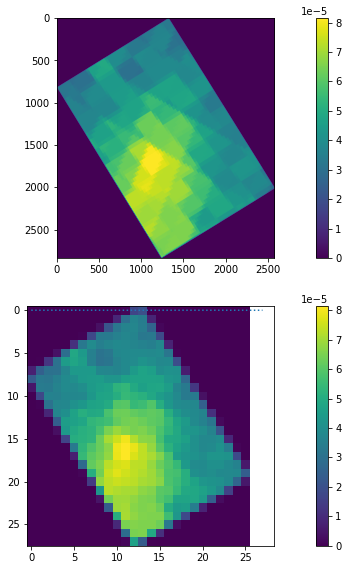

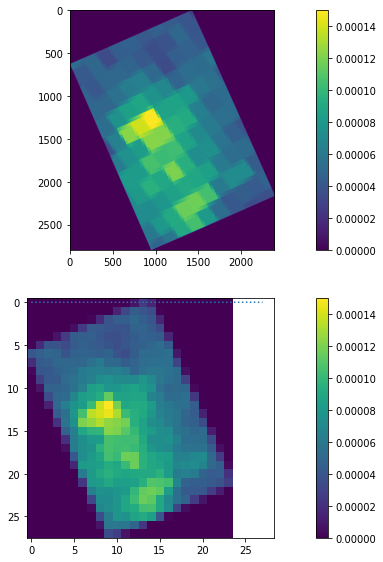

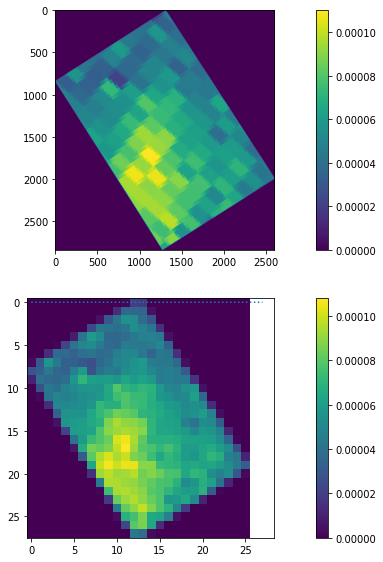

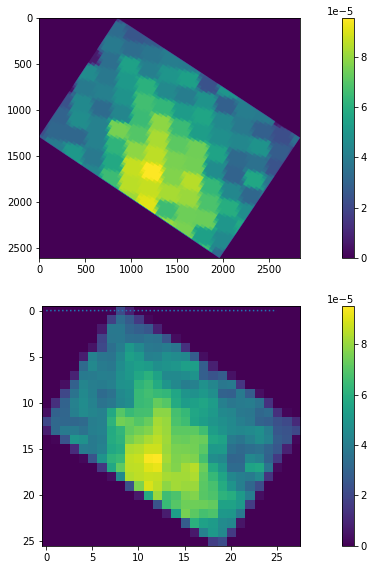

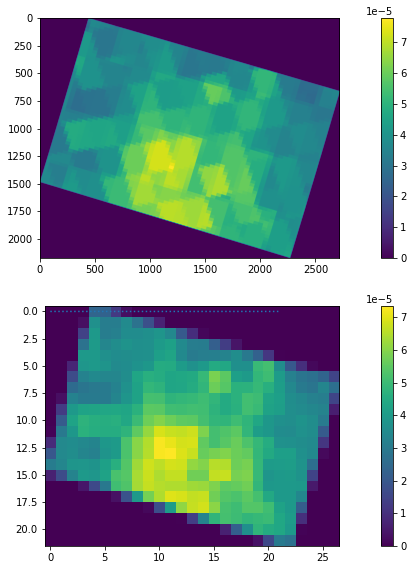

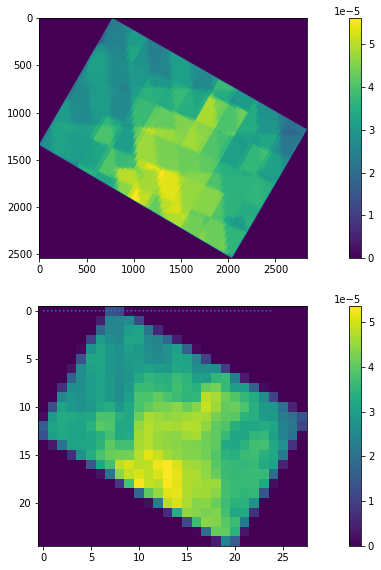

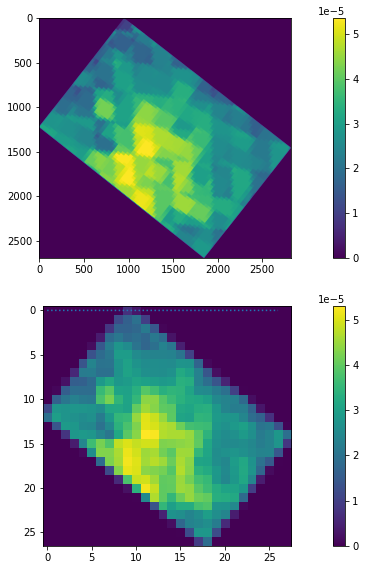

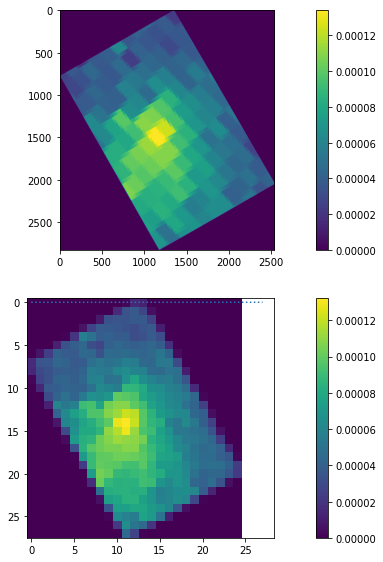

In [ ]:
#resampling
for i in  ['0526','0527','0528','0529','0530','0531','0601','0602']:
  import gdal
  ds=gdal.Open('reprojected_no2_paris_2020'+i+'.tif')
  band=ds.GetRasterBand(1)
  org_data=band.ReadAsArray()
  xsize=int(np.round((org_data.shape[1]/100),0))
  ysize=int(np.round((org_data.shape[0]/100),0))

#coarse data

  coarse_data=band.ReadAsArray(buf_xsize=xsize,buf_ysize=ysize,resample_alg=gdal.GRIORA_Average)
  import matplotlib.pyplot as plt
  plt.figure(figsize=(15,15))
  plt.subplot(3,1,1)
  plt.imshow(org_data)
  plt.colorbar() 

  plt.subplot(3,1,2)
  plt.imshow(coarse_data)
  plt.colorbar()

  #Density line plot
  import pandas as pd
  df=pd.DataFrame(coarse_data)
  df1=df.dropna()
  row_sum=df1.T.iloc[:].sum()
  #line plot
  import matplotlib.pyplot as plt
  import numpy as np

  ypoints =row_sum[:]

  plt.plot(ypoints, linestyle = 'dotted')
  plt.show()
#csv for each day corresponding to density line
  df_density=pd.DataFrame()
  df_density["dist"]=np.array(list(range(1,61,3)))
  df_density['density']=row_sum
  df_density.to_csv(r'density_2020'+i+'.csv', index=False)



## Curve Fitting and optimal parameters and NOx emission




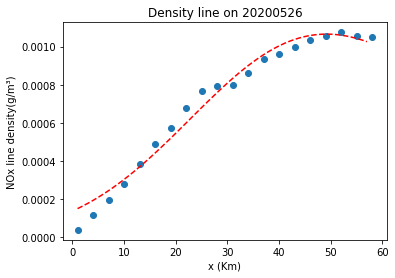

optimal parameters(a,sgmx,xnt)= [2.44753424e-03 2.04434804e+01 3.46423596e+01]
NOx emission(µg/m³) on 20200526 = 222.3307254046503


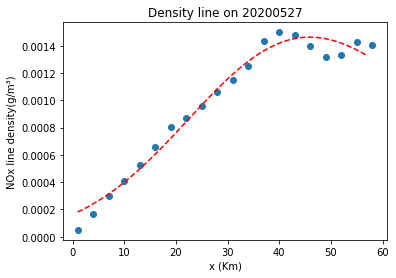

optimal parameters(a,sgmx,xnt)= [3.80993245e-03 1.89752667e+01 2.59332260e+01]
NOx emission(µg/m³) on 20200527 = 246.24341635004478


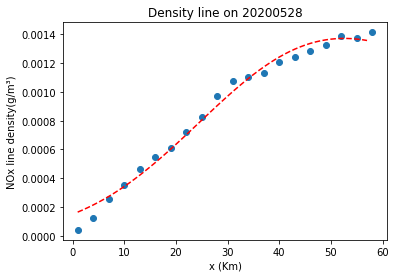

optimal parameters(a,sgmx,xnt)= [2.60680672e-03 2.01203372e+01 4.97678225e+01]
NOx emission(µg/m³) on 20200528 = 309.05906027234295


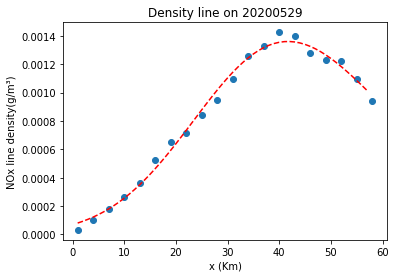

optimal parameters(a,sgmx,xnt)= [3.87274055e-03 1.51121408e+01 1.79480174e+01]
NOx emission(µg/m³) on 20200529 = 200.93552774046603


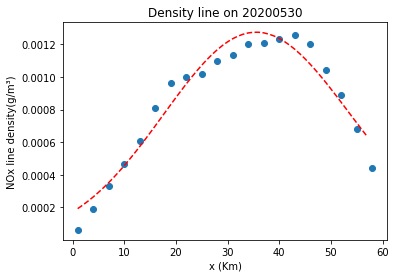

optimal parameters(a,sgmx,xnt)= [9.52959258e-03 1.71632470e+01 6.06334383e+00]
NOx emission(µg/m³) on 20200530 = 192.49496760412234


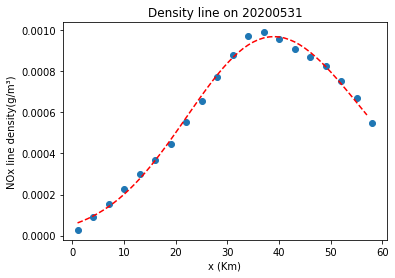

optimal parameters(a,sgmx,xnt)= [3.63143313e-03 1.48495761e+01 1.19194070e+01]
NOx emission(µg/m³) on 20200531 = 197.54448443588566


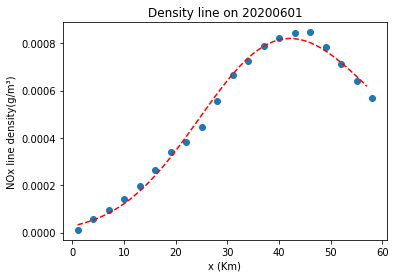

optimal parameters(a,sgmx,xnt)= [2.07558470e-03 1.40898792e+01 2.01999784e+01]
NOx emission(µg/m³) on 20200601 = 157.590453436287


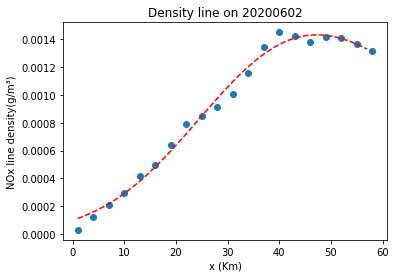

optimal parameters(a,sgmx,xnt)= [3.03386091e-03 1.70913848e+01 3.37531876e+01]
NOx emission(µg/m³) on 20200602 = 112.75083231196594


In [ ]:
Nox_emi_list=[]
for i in day_list :
  #import libraries
  import numpy as np
  #import matplotlib.pyplot as plt
  #from scipy.optimize import curve_fit
  import math
  from numpy import arange
  

  # fit a line to the economic data
  from numpy import sin
  from numpy import sqrt
  from numpy import arange
  from pandas import read_csv
  from scipy.optimize import curve_fit
  from matplotlib import pyplot
  import math
 
  # define the true objective function
  def objective(x, a, sgmx, xnt): #sgmx=sigma_x, xnt =x_0
   ob1=((a/2)*np.exp(((sgmx*sgmx)/(2*xnt*xnt))-((x-30)/(xnt))))
   ob2=(1-math.erf(((sgmx*sgmx)-(xnt*(x-30)))/(1.414*sgmx*xnt)))
   return(ob1*ob2)
  
  objective2 =np.vectorize(objective)
 
  # load the dataset
  dnsd = '/content/density_2020'+i+'.csv'
  dataframe = read_csv(dnsd)

  data = dataframe.values
  # choose the input and output variables
  x, y = data[:, 0], data[:, -1]
  # curve fit
  popt, pcov = curve_fit(objective2, x, y, p0=[1,1,1])

  # summarize the parameter values
  a, sgmx, xnt = popt

  # plot input vs output
  pyplot.scatter(x, y)
  # define a sequence of inputs between the smallest and largest known inputs
  x_line = arange(min(x), max(x), 1)
  # calculate the output for the range
  y_line = objective2(x_line,a, sgmx, xnt)
  # create a line plot for the mapping function
  pyplot.plot(x_line, y_line, '--', color='red')
  pyplot.title('Density line on 2020'+i)
  pyplot.xlabel('x (Km)')
  pyplot.ylabel('NOx line density(g/m³)')
  pyplot.gcf().subplots_adjust(left=0.15)
  
  pyplot.savefig('fig_obsVsfit_density_line_2020'+i+'.png',dpi=100)
  pyplot.show()
  print ('optimal parameters(a,sgmx,xnt)=',popt)
  z=day_list.index(i)
  print ('NOx emission(µg/m³) on 2020'+i,'=',popt[1]*WS[z])
  Nox_emi_list.append(('NOx emission(µg/m³) on 2020'+i,'=',popt[1]*WS[z]))


## NOx emission on each day

In [ ]:
Nox_emi_list

[('NOx emission(µg/m³) on 20200526', '=', 222.3307254046503),
 ('NOx emission(µg/m³) on 20200527', '=', 246.24341635004478),
 ('NOx emission(µg/m³) on 20200528', '=', 309.05906027234295),
 ('NOx emission(µg/m³) on 20200529', '=', 200.93552774046603),
 ('NOx emission(µg/m³) on 20200530', '=', 192.49496760412234),
 ('NOx emission(µg/m³) on 20200531', '=', 197.54448443588566),
 ('NOx emission(µg/m³) on 20200601', '=', 157.590453436287),
 ('NOx emission(µg/m³) on 20200602', '=', 112.75083231196594)]